In [1]:
# Common imports
import pandas as pd
import numpy as np
import scipy as sp

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cm2 = ListedColormap(['#0000aa', '#ff2020'])
cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import mglearn

在两个方面评估模型：
1. **交叉验证**：一种更可靠的评估泛化性能的方法
2. 评估分类和回归性能的方法：是在默认度量（`score`给出的精度和$R^2$）之外的方法。

**网格搜索**：一种调节监督模型参数以获得最佳泛化性能的有效方法。

## 5.1 交叉验证（cross-validation, CV）

CV的目的只是评估给定算法在特定数据集上训练后的泛化性能好坏。不是一种构建可应用于新数据的模型的方法，不会返回一个模型。

In [2]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [3]:
iris = load_iris()

In [4]:
iris.data.shape

(150, 4)

In [5]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [6]:
logistic_reg = LogisticRegression(random_state=42)

默认情况下，执行3折交叉验证（即`cv=3`），返回3个精度值:

In [7]:
cross_val_score(logistic_reg, iris.data, iris.target)  # default cv=3

array([ 0.96078431,  0.92156863,  0.95833333])

In [8]:
scores = cross_val_score(logistic_reg, iris.data, iris.target, cv=5)

In [9]:
print("CV score: {}".format(scores))

CV score: [ 1.          0.96666667  0.93333333  0.9         1.        ]


**总结CV精度的一种常用方法是计算平均值：**

In [10]:
print("Average cv score: {:.4f}".format(scores.mean()))

Average cv score: 0.9600


**折与折之间的精度有较大变化（90-100），这可能意味着模型强烈依赖于将某个折用于训练，但也可能是数据集的量太小。**

对数据进行多次划分，还可以提供模型的对训练集选择的敏感性信息。上述精度在90到100，它告诉我们将模型应用于新数据时在最坏情况和最好情况下的可能表现。

缺点：增加了计算成本。需要训练k个模型，所以交叉验证的速度比数据的单次划分大约慢k倍。

### 5.1 分层k折CV和其他交叉验证策略

从数据的前k分之一划分，可能并不好：

In [11]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Skl在**分类问题**中使用**分层K折交叉验证（stratified k-fold cross-validation）**。划分数据时使每个折中类别之间的比例与整个数据集中的比例相同。

在**回归问题**中默认使用标准k折交叉验证。

#### 5.1.1 对交叉验证的更多控制

允许提供一个**交叉验证分离器（cross-validation splitter）**作为`cv`参数，来对数据划分过程进行更精细的控制。

+ **k-fold**

`KFold`没有以'_'结尾的属性，只有`get_n_splits([X, y, groups])`和`split([X, y, groups])`方法。

In [12]:
from sklearn.model_selection import KFold

X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y = np.array(list("abcd"))

kfold = KFold(n_splits=2, random_state=42)
kfold

KFold(n_splits=2, random_state=42, shuffle=False)

In [13]:
# Returns the number of splitting iterations in the cross-validator
kfold.get_n_splits(X)

2

In [14]:
# Generate indices to split data into training and test set
train_indices, test_indices = kfold.split(X, y)   # 有y

In [15]:
for train_index, test_index in kfold.split(X):
    print("Train index: ", train_index, "Test index: ", test_index)

Train index:  [2 3] Test index:  [0 1]
Train index:  [0 1] Test index:  [2 3]


将`KFold`作为`cv`参数传入`cross_val_score`：

In [16]:
kfold = KFold(n_splits=5, random_state=42)

cross_val_score(logistic_reg, iris.data, iris.target, cv=kfold)

array([ 1.        ,  0.93333333,  0.43333333,  0.96666667,  0.43333333])

In [17]:
kfold = KFold(n_splits=3, random_state=42)

cross_val_score(logistic_reg, iris.data, iris.target, cv=kfold)

array([ 0.,  0.,  0.])

> 这样每一折对应一个类别，因此学不到任何东西。

另一种解决方法：将数据打乱来代替分层，以打乱样本按标签的排序。可以通过将`KFold`的`shuffle`参数设为`True`来实现这一点。

In [18]:
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

cross_val_score(logistic_reg, iris.data, iris.target, cv=kfold)

array([ 1.  ,  0.92,  1.  ])

#### 5.1.2 留一法交叉验证（LearveOneOut, LOO)

每折只包含一个样本的K折CV。每次划分，选择一个样本点作为测试集。对大型数据集来说非常耗时，但在小型数据集上有时可以给出更好的估计结果。

将`LeaveOneOut`作为`cv`参数传入`cross_val_score`：

In [19]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
scores = cross_val_score(logistic_reg, iris.data, iris.target, cv=loo)

print("Number of cv iterations: {}".format(len(scores)))
print("Mean accuracy: {:.4f}".format(scores.mean()))

Number of cv iterations: 150
Mean accuracy: 0.9533


In [20]:
loo.get_n_splits(iris.data)

150

#### 5.1.3 打乱划分交叉验证（ShufflSplit）

每次划分为训练集取样`train_size`个点，为测试集取样`test_size`个（不相交）点。将这一划分重复n_inter次。

`train_size`和`test_size`可以和不为1，允许每次迭代使用部分数据。

In [21]:
from sklearn.model_selection import ShuffleSplit

X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y = np.array([1, 2, 1, 2])

shuffle_split = ShuffleSplit(n_splits=3, test_size=0.25, train_size=0.5,
                             random_state=42)
shuffle_split

ShuffleSplit(n_splits=3, random_state=42, test_size=0.25, train_size=0.5)

In [22]:
shuffle_split.get_n_splits()

3

In [23]:
for train_index, test_index in shuffle_split.split(X):
    print("Train index: ", train_index, "Test index: ", test_index)

Train index:  [3 0] Test index:  [1]
Train index:  [3 0] Test index:  [1]
Train index:  [0 1] Test index:  [3]


将`ShuffleSplit`作为`cv`参数传入`cross_val_score`：

In [24]:
shuffle_split = ShuffleSplit(n_splits=10, test_size=0.5, random_state=42)

cross_val_score(logistic_reg, iris.data, iris.target, cv=shuffle_split)

array([ 0.97333333,  0.94666667,  0.85333333,  0.92      ,  0.92      ,
        0.96      ,  0.89333333,  0.88      ,  0.94666667,  0.98666667])

#### 5.1.4 分组交叉验证

In [25]:
from sklearn.model_selection import GroupKFold
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=12, random_state=0)
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]

cross_val_score(logistic_reg, X, y, groups, cv=GroupKFold(n_splits=3))

array([ 0.75      ,  0.8       ,  0.66666667])

## 5.2 网格搜索

在尝试调参之前，重要的是要理解参数的含义。

**网格搜索（grid search）**：主要是尝试关心的参数的所有可能组合。

`GridSearchCV`常用的调参方法。

In [26]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100],
              "gamma": [0.001, 0.01, 0.1, 1, 10, 100]}

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

grid_search = GridSearchCV(SVC(), param_grid=param_grid, cv=5, n_jobs=-1,
                          return_train_score=False)

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                    random_state=0)

调用`fit`时，会对`param_grid`指定的每种参数组合都运行交叉验证：

In [29]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=0)

**拟合的`GridSearchCV`对象不仅会搜索最佳参数，还会利用得到最佳交叉验证性能的参数在整个训练集上自动拟合一个新模型。**

用`predict`和`score`方法来访问重新训练过的模型。

In [30]:
grid_search.score(X_test, y_test)

0.97368421052631582

> 没有使用测试集来选择参数。

In [31]:
# 最佳模型
grid_search.best_estimator_

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [32]:
# 最佳参数
grid_search.best_params_

{'C': 100, 'gamma': 0.01}

`GridSearchCV`本身具有`predict`和`score`方法，可以不使用`best_estimator_`来进行预测或评估模型。

In [33]:
# 交叉验证最佳精度
grid_search.best_score_

0.9732142857142857

#### 5.2.1 分析交叉验证结果

运行网格搜索的成本非常高，所以通常最好从相对比较稀疏且较小的网格开始搜索。然后检查结果，可能也会扩展搜索范围。

`grid_search.cv_results_`保存网格搜索的所有结果，是一个字典。

In [34]:
results = pd.DataFrame(grid_search.cv_results_)
# 每一行对应一种特定的参数
display(results)  # 参数组合共36种

,mean_fit_time,mean_score_time,mean_test_score,param_C,param_gamma,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score
0,0.013565,0.000595,0.366071,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",22,0.375000,0.347826,0.363636,0.363636,0.380952,1.852265e-03,0.000486,0.011371
1,0.010367,0.000401,0.366071,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",22,0.375000,0.347826,0.363636,0.363636,0.380952,8.379933e-03,0.000492,0.011371
2,0.001196,0.000798,0.366071,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",22,0.375000,0.347826,0.363636,0.363636,0.380952,3.980698e-04,0.000399,0.011371
3,0.000999,0.000798,0.366071,0.001,1,"{'C': 0.001, 'gamma': 1}",22,0.375000,0.347826,0.363636,0.363636,0.380952,2.027842e-05,0.000399,0.011371
4,0.001394,0.000800,0.366071,0.001,10,"{'C': 0.001, 'gamma': 10}",22,0.375000,0.347826,0.363636,0.363636,0.380952,4.906946e-04,0.000400,0.011371
5,0.001800,0.000594,0.366071,0.001,100,"{'C': 0.001, 'gamma': 100}",22,0.375000,0.347826,0.363636,0.363636,0.380952,3.965267e-04,0.000485,0.011371
6,0.001192,0.000795,0.366071,0.01,0.001,"{'C': 0.01, 'gamma': 0.001}",22,0.375000,0.347826,0.363636,0.363636,0.380952,4.082264e-04,0.000398,0.011371
7,0.001397,0.000599,0.366071,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",22,0.375000,0.347826,0.363636,0.363636,0.380952,4.918981e-04,0.000489,0.011371
8,0.000995,0.000200,0.366071,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",22,0.375000,0.347826,0.363636,0.363636,0.380952,1.051207e-06,0.000399,0.011371
9,0.000997,0.000399,0.366071,0.01,1,"{'C': 0.01, 'gamma': 1}",22,0.375000,0.347826,0.363636,0.363636,0.380952,8.176054e-07,0.000489,0.011371


> 每一行对应一种特定的参数设置。对于每种参数设置，交叉验证所有划分的结果都被记录下来，所欲划分的平均值和标准差也被记录下来。

搜索的二维参数网格，所以最适合**热图可视化**：

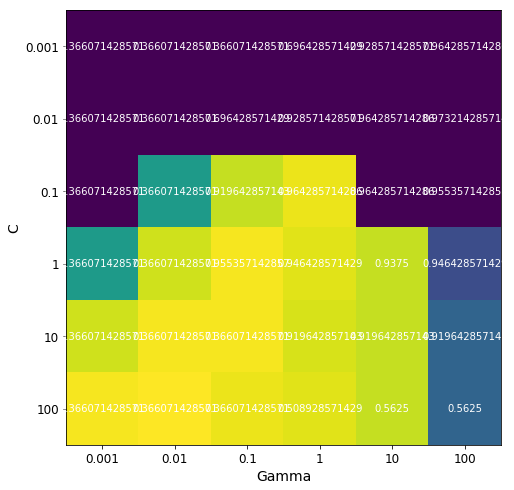

In [42]:
# 提取平均验证分数
scores = np.array(results["mean_test_score"]).reshape(6, 6)

plt.figure(figsize=(8, 8))
plt.imshow(scores, cmap=plt.cm.viridis)
plt.xlabel("Gamma")
plt.ylabel("C")
plt.xticks(np.arange(len(param_grid["gamma"])), param_grid["gamma"])
plt.yticks(np.arange(len(param_grid["C"])), param_grid["C"])

for i in range(len(param_grid["C"])):
    for j in range(len(param_grid["gamma"])):
        plt.text(i, j, scores[i, j], ha="center", va="center", color="w")
plt.show()

> 热图中每个点对应于运行一次交叉验证以及一种特定的参数设置。要注意，参数的范围要足够大：每个参数的最佳取值不能位于图像的边界上。

#### 5.2.2 在非网格的空间搜索

`param_grid`可以是字典组成的列表。列表中的每个字典可扩展为一个独立的网格。

In [46]:
param_grid = [{"kernel": ["rbf"],
               "C": [0.001, 0.01, 0.1, 1, 10, 100],
               "gamma": [0.001, 0.01, 0.1, 1, 10, 100]},
              {"kernel": ["linear"],
               "C": [0.001, 0.01, 0.1, 1, 10, 100]}]

In [51]:
grid_search = GridSearchCV(SVC(), param_grid=param_grid, cv=5, n_jobs=-1,
                           return_train_score=False)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=0)

In [52]:
grid_search.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [53]:
grid_search.best_score_

0.9732142857142857

In [54]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,param_C,param_gamma,param_kernel,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score
0,0.012501,0.000000,0.366071,0.001,0.001,rbf,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}",27,0.375000,0.347826,0.363636,0.363636,0.380952,0.006250,0.000000,0.011371
1,0.006243,0.000000,0.366071,0.001,0.01,rbf,"{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}",27,0.375000,0.347826,0.363636,0.363636,0.380952,0.007646,0.000000,0.011371
2,0.000000,0.000000,0.366071,0.001,0.1,rbf,"{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}",27,0.375000,0.347826,0.363636,0.363636,0.380952,0.000000,0.000000,0.011371
3,0.000000,0.000000,0.366071,0.001,1,rbf,"{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}",27,0.375000,0.347826,0.363636,0.363636,0.380952,0.000000,0.000000,0.011371
4,0.000000,0.000000,0.366071,0.001,10,rbf,"{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}",27,0.375000,0.347826,0.363636,0.363636,0.380952,0.000000,0.000000,0.011371
5,0.000000,0.000000,0.366071,0.001,100,rbf,"{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}",27,0.375000,0.347826,0.363636,0.363636,0.380952,0.000000,0.000000,0.011371
6,0.000000,0.000000,0.366071,0.01,0.001,rbf,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}",27,0.375000,0.347826,0.363636,0.363636,0.380952,0.000000,0.000000,0.011371
7,0.000000,0.000000,0.366071,0.01,0.01,rbf,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}",27,0.375000,0.347826,0.363636,0.363636,0.380952,0.000000,0.000000,0.011371
8,0.000599,0.000200,0.366071,0.01,0.1,rbf,"{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}",27,0.375000,0.347826,0.363636,0.363636,0.380952,0.000489,0.000399,0.011371
9,0.000599,0.000599,0.366071,0.01,1,rbf,"{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",27,0.375000,0.347826,0.363636,0.363636,0.380952,0.000489,0.000489,0.011371


#### 2.4.3 使用不同的交叉验证策略进行网格搜索

`GridSearchCV`对分类问题默认使用分层K折交叉验证，对回归问题默认使用K折交叉验证。但可以传入任何交叉验证分离器作为`GridSearchCV`的`cv`参数。

如果只想将数据单次划分为训练集和验证集，可以使用`ShuffleSplit`或StratifiedShuffleSplit`，并设置n_iter=1。这对于非常大的数据集或非常慢的模型可能有帮助。

+ **嵌套交叉验证（nested cross-validation）**

不是只将原始数据一次划分为训练集和测试集，而是使用交叉验证进行多次划分。有一个外层循环，遍历将数据划分为训练集和测试集的所有划分。对于每一种划分都运行一次网格搜索（对于外层循环的每种划分可能会得到不同的最佳参数）。然后，对于每种外层划分，利用最佳参数设置计算得到测试分数。

这一过程的结果是由分数组成的列表——不是一个模型，也不是一种参数设置。这些分数告诉我们在网格中找到的最佳参数模型下泛化能力好坏。

由于**嵌套交叉验证不提供可用于新数据的模型**，所以**在寻找可用于未来数据的预测模型时很少用到它**。但是它**对于评估模型在特定数据集上的效果很有用**。

In [59]:
scores = cross_val_score(
    GridSearchCV(SVC(), param_grid=param_grid, cv=5, n_jobs=-1,
                 return_train_score=False), iris.data, iris.target, cv=5, n_jobs=-1)

In [56]:
scores

array([ 0.96666667,  1.        ,  0.9       ,  0.96666667,  1.        ])

In [57]:
scores.mean()

0.96666666666666679

> 可以总结为SVC在iris数据集上的交叉验证平均精度为96.7%。

## 5.3 评估指标与评分

在选择模型与调参时，选择正确的指标是很重要的。

选择指标时，应该始终牢记机器学习应用的最终目标。

### 5.3.1 二分类指标

对二分类问题，通常会说**正类（positive class）**和**反类（negative class），而正类是要寻找的类。

+ **1  错误类型**

假正类（false positive）/第一类错误（type I error）

假反类（false negative）/第二类错误（type II error）

+ **2 不平衡数据集**

一个类别比另一个类别出现次数多很多的数据集，通常叫做**不平衡数据集**或**具有不平衡类别的数据集**。在实际中，不平衡数据集才是常态，而数据中感兴趣的出现次数相同或相似的情况十分罕见。

将digits数据集中的9与其他几类加以区分：

In [61]:
from sklearn.datasets import load_digits

digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(digits.data, y,
                                                    random_state=42)

In [65]:
print("shape of X_train: {}".format(X_train.shape))
print("shape of X_test: {}".format(X_test.shape))

shape of X_train: (1347, 64)
shape of X_test: (450, 64)


使用**`DummyClassifier`**来始终预测多数类：

In [67]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=42, strategy='most_frequent')

In [68]:
# 预测的结果
pred_most_freq = dummy_clf.predict(X_test)
np.unique(pred_most_freq, return_counts=True)

(array([False], dtype=bool), array([450], dtype=int64))

In [70]:
# 真实情况
np.unique(y_test, return_counts=True)

(array([False,  True], dtype=bool), array([402,  48], dtype=int64))

In [71]:
dummy_clf.score(X_test, y_test)

0.89333333333333331

> 精度89%，但没有学到任何内容。

使用决策树进行分类：

In [74]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_depth=2, random_state=42).fit(X_train, y_train)
pred_dt = dt_clf.predict(X_test)
dt_clf.score(X_test, y_test)

0.91555555555555557

> 仅比常数预测好一点，这可能表示使用决策树有误，也可能是精度不是一个很好的度量。

再对比两个分类器——`LogisticRegression`和默认的`DummyClassifier`（随机预测，但预测类别的比例与训练集中相同）：

In [75]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42).fit(X_train, y_train)
pred_logreg = log_reg.predict(X_test)
log_reg.score(X_test, y_test)

0.97555555555555551

In [76]:
dummy_clf = DummyClassifier(random_state=42).fit(X_train, y_train)
pred_dummy = dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

0.81333333333333335

> 随机输出的分类器最差，但也有81%的精度。这样很难判断哪些结果是真正有帮助的。

**要想对这种不平衡数据的性能进行量化，精度并不是一种合适的度量。**

+ **3 混淆矩阵（confusion matrix）**

对于分类问题的评估，一种最全面的表示方法是使用**混淆矩阵**。

In [82]:
dt_clf.classes_

array([False,  True], dtype=bool)

**对于二分类问题，“反类”始终是`classes_`属性的第一个元素，“正类”是第二个元素。**

In [84]:
np.unique(y_test, return_counts=True)

(array([False,  True], dtype=bool), array([402,  48], dtype=int64))

In [77]:
from sklearn.metrics import confusion_matrix

In [78]:
confusion_matrix(y_test, pred_logreg)

array([[397,   5],
       [  6,  42]], dtype=int64)

行对应于真实的类别，列对应于预测的类别。数组中每个元素给出该行对应类别的样本被分到该列对应的类别中的数量。

混淆矩阵的解释：

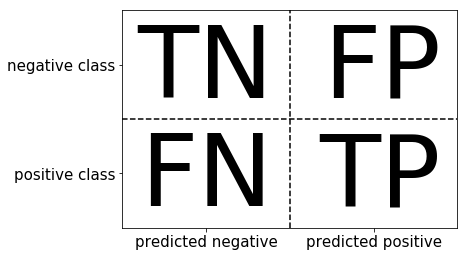

In [79]:
mglearn.plots.plot_binary_confusion_matrix()

混淆矩阵主对角线上对应于正确的分类，而其他元素告诉我们一个类别中有多少样本被错误地划分到其他类别中。

In [80]:
print("most frequent class:")
print(confusion_matrix(y_test, pred_most_freq))
print("\ndummy model:")
print(confusion_matrix(y_test, pred_dummy))
print("\ndecision tree:")
print(confusion_matrix(y_test, pred_dt))
print("\nlogistic regression:")
print(confusion_matrix(y_test, pred_logreg))

most frequent class:
[[402   0]
 [ 48   0]]

dummy model:
[[362  40]
 [ 44   4]]

decision tree:
[[376  26]
 [ 12  36]]

logistic regression:
[[397   5]
 [  6  42]]


> 可以看出决策树和Logistic回归给出了合理的结果，并且Logistic回归的效果优于决策树。

**Accuracy**：是正确预测的数量（TP和TN）除以所有样本的数量。

$$Accuracy = \frac{{TP} + {TN}}{{TP}+{TN}+{FP}+{FN}}$$

**Precision**：被预测为正类的样本中有多少是真正的正类。如果目标是限制假正类的数量，可用。

$$Precision=\frac{TP}{TP+FP}$$


**Recall**：度量的是正类样本中有多少被预测为正类。如果需要找出所有的正类样本即避免反类很重要的情况下，使用recall作为性能指标。

$$Recall = \frac{TP}{TP+FN}$$

**在优化Precision和Recall之间需要折中。**在机器学习中，二者是最常用的二分类度量指标。

**F1-score/F-score/F-measure**：将recall和precision进行汇总的一种方法，是两者的调和平均。同时考虑了precision和recall，所以**对于不平衡的二分类数据集来说是一种比accuarcy更好的度量**。

$$F-score = 2 \times {\frac{precision \times recall}{precision+recall}}$$

In [87]:
from sklearn.metrics import f1_score

print("most frequent class:")
print(f1_score(y_test, pred_most_freq))
print("\ndummy model:")
print(f1_score(y_test, pred_dummy))
print("\ndecision tree:")
print(f1_score(y_test, pred_dt))
print("\nlogistic regression:")
print(f1_score(y_test, pred_logreg))

most frequent class:
0.0

dummy model:
0.0869565217391

decision tree:
0.654545454545

logistic regression:
0.884210526316


C:\Users\libin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


> 警告的原因：most frequent class中计算`f1_score`时分母为0。

可以看到虚拟预测与模型之间的差异很大，利用`f1_score`进行评估效果更好。

但是，**f_score**比精度更加难以解释。

**`classification_report`**同时计算这三个值：

In [89]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_most_freq,
                            target_names=["not nine", "nine"]))

             precision    recall  f1-score   support

   not nine       0.89      1.00      0.94       402
       nine       0.00      0.00      0.00        48

avg / total       0.80      0.89      0.84       450



C:\Users\libin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [90]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_dummy,
                            target_names=["not nine", "nine"]))

             precision    recall  f1-score   support

   not nine       0.89      0.90      0.90       402
       nine       0.09      0.08      0.09        48

avg / total       0.81      0.81      0.81       450



In [91]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_dt,
                            target_names=["not nine", "nine"]))

             precision    recall  f1-score   support

   not nine       0.97      0.94      0.95       402
       nine       0.58      0.75      0.65        48

avg / total       0.93      0.92      0.92       450



In [92]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_logreg,
                            target_names=["not nine", "nine"]))

             precision    recall  f1-score   support

   not nine       0.99      0.99      0.99       402
       nine       0.89      0.88      0.88        48

avg / total       0.98      0.98      0.98       450



`classification_report`函数为每个类别（这里是True和False）生成一行，并给出以该类别作为正类的precision、recall和f-score。最后一行显示的是对应指标的加权平均（按每个类别中的样本个数加权）。

**选择哪个作为正类对指标有很大影响。**而且，同时查看所有情况可以给出非常准确的图像，可以清楚看到Logistic回归的优势。

+ **4 考虑不确定性**

`confusion_matrix`和`classification_report`为一组特定的预测提供了非常详细的分析。但是，预测本身已经丢弃了模型中包含的大量信息。

In [100]:
from mglearn.datasets import make_blobs

X, y = make_blobs(n_samples=(400, 50), centers=2, cluster_std=[7.0, 2],
                  random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [102]:
np.unique(y, return_counts=True)

(array([0, 1]), array([400,  50], dtype=int64))

> 不平衡二分类。反类有400个，正类只有50个。

In [103]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([296,  41], dtype=int64))

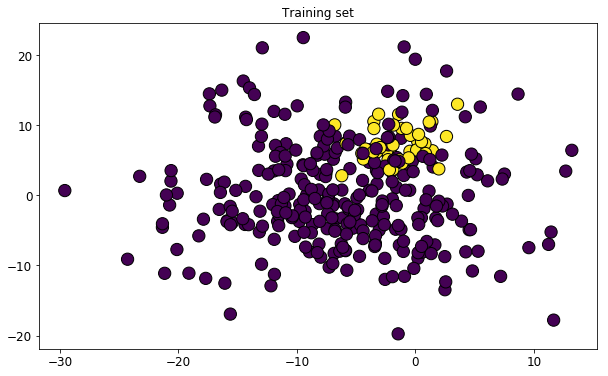

In [110]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=150, edgecolors="k")
plt.title("Training set")
plt.show()

In [134]:
svc = SVC(gamma=0.05).fit(X_train, y_train)

In [135]:
print(classification_report(y_test, svc.predict(X_test)))

             precision    recall  f1-score   support

          0       0.97      0.89      0.93       104
          1       0.35      0.67      0.46         9

avg / total       0.92      0.88      0.89       113



> 对于类别1，precision相当低，而recall则令人mixed。由于类别0要大得多，所以分类器将重点放在类别0分类正确，而不是较小的类别1。

假设类别1具有高recall更加重要，这意味着愿意有更多的假类别1，以换取更多的真类别1（增大recall）。

可以通过改变决策阈值不等于0来将预测重点放在使类别1的recall更高。**默认情况下，`decision_function`值大于0的点被预测为类别1。希望将更多的点划分为1，需要减小阈值**：

In [136]:
# 默认情况下，阈值为0
svc.decision_function(X_test)

array([-0.99973208, -1.00148617, -1.1386043 , -0.98505482, -1.01044247,
       -1.00027441, -1.00609413,  0.88395198, -1.00467053, -1.00283866,
       -1.00097712,  1.07030762, -1.02076344, -0.40435353, -0.48739733,
       -1.00121046, -1.09560781, -1.44572917, -0.99908802, -1.00070245,
       -0.44364565, -1.01170286, -0.99918954, -1.0861769 , -1.33291363,
       -1.00320657, -0.99076097, -1.09564958,  0.63212214, -0.99238394,
       -1.47090403,  0.19153373,  0.74430046, -1.0084656 , -1.15104651,
       -1.02852903, -1.00840776, -1.23180696, -1.0031964 , -1.00023926,
       -1.0013854 , -1.00003771, -1.10114776, -0.98779744, -1.05818617,
       -1.00105363,  0.5230006 ,  0.97789353, -0.99559099,  0.52008479,
       -1.25711078, -1.08267667, -0.99828696, -1.00385465,  0.08620484,
       -0.99871026, -1.06221884, -1.02415268, -1.08797969, -1.06010122,
        0.36988055, -1.05630237, -0.99981001, -0.24173165, -1.02857919,
       -1.00058106, -0.99968788, -1.00115386, -0.99882791,  1.25

In [137]:
svc.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

减小阈值至-0.8：

In [138]:
svc.decision_function(X_test) > -0.8

array([False, False, False, False, False, False, False,  True, False,
       False, False,  True, False,  True,  True, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False,  True, False, False, False, False,
        True, False, False, False, False, False,  True, False, False,
        True, False, False, False, False, False,  True, False, False,
       False,  True,  True, False, False, False,  True, False, False,
        True, False, False,  True, False,  True, False,  True, False,
       False,  True, False, False, False,  True, False, False, False,
        True, False, False, False,  True, False, False,  True, False,
       False, False,  True, False, False], dtype=bool)

In [139]:
y_pred_lower_threshold = svc.decision_function(X_test) > -0.8

In [140]:
print(classification_report(y_test, y_pred_lower_threshold))

             precision    recall  f1-score   support

          0       1.00      0.82      0.90       104
          1       0.32      1.00      0.49         9

avg / total       0.95      0.83      0.87       113



> 类别1的recall增大。

如果认为precision比recall更重要，或者反过来，或者数据严重不平衡，那么改变决策阈值是得到更好结果的最简单方法。由于`decision_function`的取值可能在任意范围内，所以很难提供关于如何选取阈值的经验法则。

如果设置了阈值，那么小心不要在测试集上这么做。与其他任何参数一样，在测试集上设置决策阈值可能会得到过于乐观的结果。可以使用验证集或交叉验证来代替。

对于实现了`predict_proba`方法的模型来说，选择阈值可能更简单。默认情况下，0.5的阈值表示，如果模型超过0.5的概率”确信“一个点属于正类，那么就将其划分为正类。增大阈值意味着模型需要更加确信才能做出正类的判断（较低程度的确信就可以做出反类的判断）。

**改变模型中用于做出分类决策的阈值，是一种调节给定分类器的precision和recall之间折中的方法。**

+ **5 precision-recall曲线**

总是可以设定一个阈值来满足特定的目标。**难点**在于开发一个模型，在满足这个阈值的同时仍具有合理的precision。

对分类器设置要求（如90%的recall）通常被称为设置**工作点（operating point）**。设置工作点通常有助于为客户或组织内的其他小组提供性能保证。

在开发新模型时，并完全不清楚工作点在哪里。同时查看所有可能的阈值或所有可能的recall和precision的折中。使用`precision_recall_curve`可以做到。

In [141]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

> 函数返回一个列表，包含按升序排序的所有可能阈值以及对应的precision和recall(按降序排)。

In [142]:
precision

array([ 0.32142857,  0.2962963 ,  0.30769231,  0.32      ,  0.33333333,
        0.34782609,  0.36363636,  0.38095238,  0.4       ,  0.36842105,
        0.33333333,  0.35294118,  0.375     ,  0.4       ,  0.42857143,
        0.38461538,  0.41666667,  0.45454545,  0.4       ,  0.44444444,
        0.5       ,  0.57142857,  0.66666667,  0.6       ,  0.5       ,
        0.66666667,  0.5       ,  1.        ,  1.        ])

In [143]:
recall

array([ 1.        ,  0.88888889,  0.88888889,  0.88888889,  0.88888889,
        0.88888889,  0.88888889,  0.88888889,  0.88888889,  0.77777778,
        0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.66666667,
        0.55555556,  0.55555556,  0.55555556,  0.44444444,  0.44444444,
        0.44444444,  0.44444444,  0.44444444,  0.33333333,  0.22222222,
        0.22222222,  0.11111111,  0.11111111,  0.        ])

In [144]:
thresholds

array([-0.7512563 , -0.58749402, -0.48739733, -0.44364565, -0.40435353,
       -0.28965335, -0.24173165, -0.19257469, -0.17852475, -0.16644845,
       -0.1601932 ,  0.08620484,  0.14630375,  0.19153373,  0.36988055,
        0.52008479,  0.5230006 ,  0.53195462,  0.63212214,  0.74430046,
        0.87212596,  0.88002558,  0.88395198,  0.97789353,  1.00010384,
        1.07030762,  1.08436417,  1.25059991])

> `precision`和`recall`的最后一个值分别为1.和0.，固定的，不对应任何阈值，故它俩的长度比`thresholds`大1。

In [158]:
rf_clf.predict_proba(X_test)[:, 1]

array([ 0.59,  0.  ,  0.  , ...,  0.  ,  0.11,  0.  ])

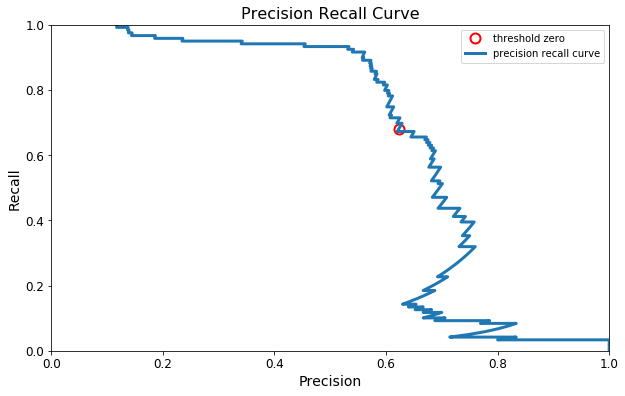

In [159]:
X, y = make_blobs(n_samples=(4000, 500), centers=2, cluster_std=[7.0, 2.],
                  random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)
svc = SVC(gamma=.05, random_state=42).fit(X_train, y_train)
precisions, recalls, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test))

plt.figure(figsize=(10, 6))
# 0是decision_function的默认阈值，找到最近0的阈值
close2zero = np.argmin(np.abs(thresholds))
plt.plot(precisions[close2zero], recalls[close2zero], "ro", markersize=10,
         label="threshold zero", fillstyle="none", mew=2)
plt.plot(precisions, recalls, linewidth=3, label="precision recall curve")
plt.legend(loc="best")
plt.xlim(0.0, 1.)
plt.ylim(0.0, 1.0)
plt.xlabel("Precision", fontsize=14)
plt.ylabel("Recall", fontsize=14)
plt.title("Precision Recall Curve", fontsize=16)
plt.show()

曲线上每一个点都对应`decision_function`的一个可能阈值。红色圈表示阈值为0的点，0是`decision_function`的默认阈值，这个点是在调用`predict`方法时所选择的折中点。

**曲线越靠近右上角，则分类器越好。**右上角的点表示同一个阈值，precision和recall都很高。曲线从左上角开始，这里对应非常低的阈值，将所有样本都划分为正类。提高阈值可以让曲线向precision更高的方向移动，但同时recall降低。继续增大阈值，大多数点被分类正类的点都是真正类，此时precision很高，但recall更低。**随着precision的升高，模型越能够保持较高的recall，则模型越好。**

想要更高的precision，那么就必须牺牲很多recall。

比较SVM和随机森林：

In [161]:
thresholds_rf

array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
        0.09,  0.1 ,  0.11,  0.12,  0.13,  0.15,  0.16,  0.17,  0.18,
        0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,  0.27,
        0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,  0.37,
        0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,  0.45,  0.46,  0.47,
        0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,  0.54,  0.55,  0.56,
        0.57,  0.58,  0.59,  0.6 ,  0.61,  0.62,  0.63,  0.64,  0.65,
        0.67,  0.68,  0.69,  0.7 ,  0.71,  0.72,  0.73,  0.74,  0.75,
        0.76,  0.77,  0.78,  0.8 ,  0.81,  0.82,  0.83,  0.84,  0.85,
        0.86,  0.87,  0.88,  0.89,  0.91,  0.93,  0.95,  0.96,  0.97,
        0.98,  0.99,  1.  ])

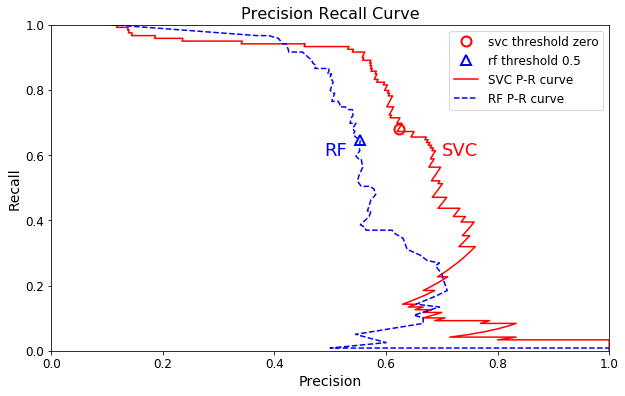

In [174]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=100, max_features=2, random_state=0)
rf_clf.fit(X_train, y_train)

# 传入样本属于类别1的概率
precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(
    y_test, rf_clf.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
# predict_proba的阈值是0.5，标出这个点
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
# 0是decision_function的默认阈值，找到最近0的阈值
close2zero = np.argmin(np.abs(thresholds))
plt.plot(precisions[close2zero], recalls[close2zero], "ro", markersize=10,
         mew=2, label="svc threshold zero", fillstyle="none")
plt.plot(precisions_rf[close_default_rf], recalls_rf[close_default_rf], "b^",
         markersize=10, mew=2, label="rf threshold 0.5", fillstyle="none")

plt.plot(precisions, recalls, "r-", label="SVC P-R curve")
plt.plot(precisions_rf, recalls_rf, "b--", label="RF P-R curve")

plt.text(0.49, 0.6, "RF", color="b", fontdict={"fontsize": 18})
plt.text(0.7, 0.6, "SVC", color="r", fontdict={"fontsize": 18})
plt.legend(loc="best", fontsize="large")
plt.xlim(0.0, 1.)
plt.ylim(0.0, 1.0)
plt.xlabel("Precision", fontsize=14)
plt.ylabel("Recall", fontsize=14)
plt.title("Precision Recall Curve", fontsize=16)
plt.show()

f-score只反映precision-recall曲线上的一个点，即默认阈值对应的那个点：

In [176]:
print("f-score of RF: {:.4f}".format(f1_score(y_test, rf_clf.predict(X_test))))
print("f-score of SVC: {:.4f}".format(f1_score(y_test, svc.predict(X_test))))

f-score of RF: 0.5850
f-score of SVC: 0.6506


对于自动化模型对比，希望可以总结曲线中包含的信息，而不限于某个特定的阈值或工作点。**总结precision-recall曲线的一种方法是计算该曲线下的积分或面积**，叫做**平均准确率（average precision）**。

In [178]:
from sklearn.metrics import average_precision_score

ap_rf = average_precision_score(y_test, rf_clf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))

print("Average precision of RF: {:.4f}".format(ap_rf))
print("Average precision of SVC: {:.4f}".format(ap_svc))

Average precision of RF: 0.5639
Average precision of SVC: 0.6582


+ **6 ROC与AUC**

**ROC曲线**是分析不同阈值的分类器行为另一种常用工具。与P-R曲线类似，ROC曲线考虑了给定分类器的所有可能的阈值，但它**显示的是假正类率（false positive rate, FPR）和真正类率（true positive rate, TPR）**，而不是报告precision和recall。

**真正类率（true positive rate, TPR）**是recall的另一个名称。
$$TPR(recall) = \frac{TP}{TP+FN}$$

**假正类率（false positive rate, FPR）**是假正类占所有反类样本的比例。
$$FPR=\frac{FP}{FP+TN}$$

In [179]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

In [180]:
fpr

array([  0.00000000e+00,   0.00000000e+00,   9.94035785e-04,
         9.94035785e-04,   1.98807157e-03,   1.98807157e-03,
         2.98210736e-03,   2.98210736e-03,   4.97017893e-03,
         4.97017893e-03,   5.96421471e-03,   5.96421471e-03,
         6.95825050e-03,   6.95825050e-03,   7.95228628e-03,
         7.95228628e-03,   8.94632207e-03,   8.94632207e-03,
         9.94035785e-03,   9.94035785e-03,   1.09343936e-02,
         1.09343936e-02,   1.19284294e-02,   1.19284294e-02,
         1.39165010e-02,   1.39165010e-02,   1.49105368e-02,
         1.49105368e-02,   1.68986083e-02,   1.68986083e-02,
         1.88866799e-02,   1.88866799e-02,   2.28628231e-02,
         2.28628231e-02,   2.58449304e-02,   2.58449304e-02,
         2.68389662e-02,   2.68389662e-02,   2.88270378e-02,
         2.88270378e-02,   3.18091451e-02,   3.18091451e-02,
         3.28031809e-02,   3.28031809e-02,   3.37972167e-02,
         3.37972167e-02,   3.47912525e-02,   3.47912525e-02,
         3.57852883e-02,

In [181]:
tpr

array([ 0.00840336,  0.03361345,  0.03361345,  0.04201681,  0.04201681,
        0.08403361,  0.08403361,  0.09243697,  0.09243697,  0.10084034,
        0.10084034,  0.11764706,  0.11764706,  0.12605042,  0.12605042,
        0.13445378,  0.13445378,  0.14285714,  0.14285714,  0.18487395,
        0.18487395,  0.22689076,  0.22689076,  0.31932773,  0.31932773,
        0.35294118,  0.35294118,  0.39495798,  0.39495798,  0.41176471,
        0.41176471,  0.43697479,  0.43697479,  0.47058824,  0.47058824,
        0.51260504,  0.51260504,  0.5210084 ,  0.5210084 ,  0.56302521,
        0.56302521,  0.58823529,  0.58823529,  0.61344538,  0.61344538,
        0.62184874,  0.62184874,  0.6302521 ,  0.6302521 ,  0.63865546,
        0.63865546,  0.64705882,  0.64705882,  0.65546218,  0.65546218,
        0.67226891,  0.67226891,  0.69747899,  0.69747899,  0.71428571,
        0.71428571,  0.72268908,  0.72268908,  0.74789916,  0.74789916,
        0.78151261,  0.78151261,  0.78991597,  0.78991597,  0.79

In [182]:
thresholds

array([ 1.44298211,  1.40134791,  1.3975429 ,  1.38758898,  1.38278276,
        1.32948813,  1.32173581,  1.31930821,  1.29857712,  1.29218234,
        1.28110419,  1.24007113,  1.23141424,  1.22893034,  1.22218086,
        1.22117673,  1.21100544,  1.20716553,  1.20389872,  1.17476892,
        1.16858499,  1.1404164 ,  1.13205005,  1.00772875,  0.98365543,
        0.92245317,  0.90045061,  0.82753516,  0.81813586,  0.81091518,
        0.78895562,  0.77188417,  0.72928687,  0.70730122,  0.67965771,
        0.63392527,  0.60983555,  0.60699679,  0.5902446 ,  0.49677837,
        0.44136415,  0.37841613,  0.37840264,  0.35633969,  0.34869415,
        0.33740349,  0.32443636,  0.322434  ,  0.28840151,  0.28832802,
        0.28204345,  0.27485506,  0.26181866,  0.25769925,  0.18304461,
        0.17265065,  0.03882988, -0.06357833, -0.10568517, -0.14421264,
       -0.1903719 , -0.19090777, -0.19644623, -0.27448098, -0.30322017,
       -0.33140164, -0.34277311, -0.34360853, -0.34502207, -0.35

In [183]:
print("length of fpr: {}".format(len(fpr)))
print("length of tpr: {}".format(len(tpr)))
print("length of thresholds: {}".format(len(thresholds)))

length of fpr: 113
length of tpr: 113
length of thresholds: 113


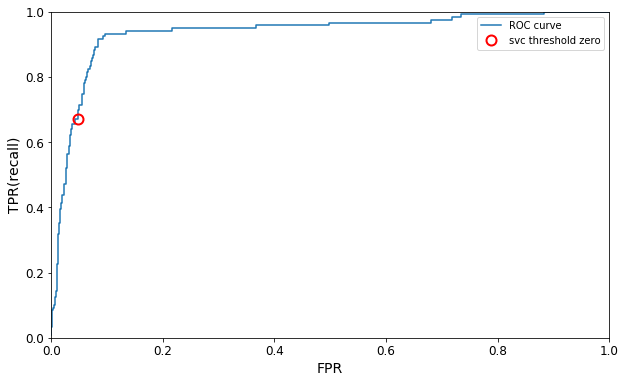

In [185]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="ROC curve")
# 0是decision_function的默认阈值，找到最近0的阈值
close2zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close2zero], tpr[close2zero], "ro", markersize=10,
         mew=2, label="svc threshold zero", fillstyle="none")
plt.legend(loc="best")
plt.xlim(0.0, 1.)
plt.ylim(0.0, 1.0)
plt.xlabel("FPR", fontsize=14)
plt.ylabel("TPR(recall)", fontsize=14)
plt.show()

**理想的ROC曲线要靠近左上角：分类器的准确率很高，同时保证假正类率（FPR）很低。**

最接近左上角的点可能是比默认选择更好的工作点。

同样，不应该在测试集上选择阈值，而是应该在单独的验证集上选择。

对比SVC和随机森林：

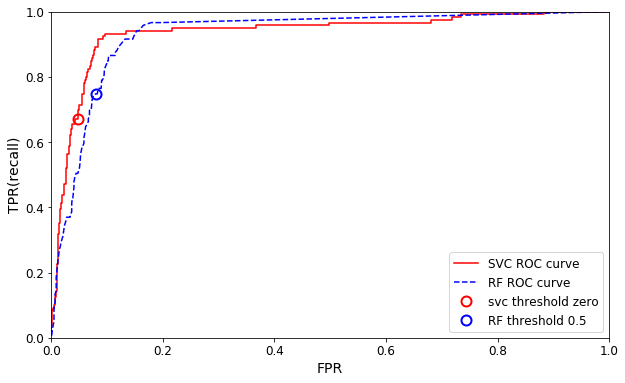

In [188]:
# 随机森林的ROC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(
    y_test, rf_clf.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, "r-", label="SVC ROC curve")
plt.plot(fpr_rf, tpr_rf, "b--", label="RF ROC curve")

# 0是decision_function的默认阈值，找到最近0的阈值
close2zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close2zero], tpr[close2zero], "ro", markersize=10,
         mew=2, label="svc threshold zero", fillstyle="none")
# 0.5是predict_proba的默认阈值，找打最接近0.5的阈值
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close2zero], tpr_rf[close2zero], "bo", markersize=10,
         mew=2, label="RF threshold 0.5", fillstyle="none")
plt.legend(loc="best", fontsize="large")
plt.xlim(0.0, 1.)
plt.ylim(0.0, 1.0)
plt.xlabel("FPR", fontsize=14)
plt.ylabel("TPR(recall)", fontsize=14)
plt.show()

**用AUC（ROC曲线下的面积）来总结ROC曲线**：

In [191]:
from sklearn.metrics import roc_auc_score

auc_rf = roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1])
auc_svc = roc_auc_score(y_test, svc.decision_function(X_test))

print("AUC for RF: {:.4f}".format(auc_rf))
print("AUC for SVC: {:.4f}".format(auc_svc))

AUC for RF: 0.9305
AUC for SVC: 0.9358
